# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import json
import os

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0]
#run_info = run_info.query('path=="runs/14Nov20-202818-2f4d2c"').iloc[0]  # XTB run
print(run_info)

path                                runs/small_basis-02Dec20-141127-c25cc7
param_hash                                                          c25cc7
start_time                                             2020-12-02 14:11:27
mpnn_config_directory      ../../ai-components/mpnn/nwchem-atomization-v0/
mpnn_model_files         ['../../ai-components/mpnn/nwchem-atomization-...
search_space             ../../ai-components/search-spaces/G13-filtered...
qc_spec                                                        small_basis
qc_parallelism                                                           1
parallel_guesses                                                         1
search_size                                                           1000
molecules_per_ml_task                                                10000
sampling_fraction                                                     0.01
nnodes                                                                 128
qc_workers               

## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
result_data = pd.read_json(os.path.join(run_info['path'], 'simulation_records.jsonld'), lines=True)
result_data.sort_values('time_created', inplace=True)

In [5]:
result_data.reset_index(inplace=True)

Plot the time since first result

In [6]:
result_data['walltime'] = result_data['time_result_received'] - result_data['time_created'].min()

Plot the rate at which we aquired new results

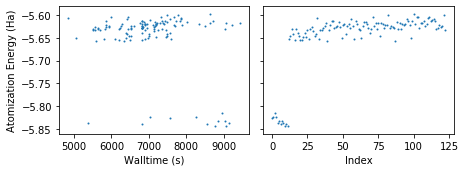

In [7]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.5))

axs[1].scatter(result_data.index, result_data['value'], s=1)
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Atomization Energy (Ha)')

axs[0].scatter(result_data['walltime'], result_data['value'], s=1)
axs[0].set_xlabel('Walltime (s)')

fig.tight_layout()
fig.savefig('figures/optimizer-performance.svg')

## Evaluate Runtimes
Estimate the runtimes of the QC code

In [8]:
screen_data = pd.read_json(os.path.join(run_info['path'], 'inference_records.jsonld'), lines=True)

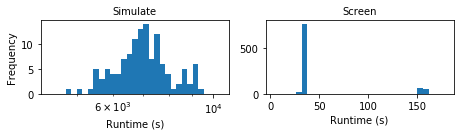

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.))


for data, label, ax in zip([result_data, screen_data], ['Simulate', 'Screen'], axs.flatten()):
    if label == "Simulate":
        wt_range = np.log10([data['time_running'].min() * 0.9,
                             data['time_running'].max() * 1.1])
        bins = np.logspace(*wt_range, 32)
        ax.set_xscale('log')
    else:
        wt_range = [data['time_running'].min() * 0.9, data['time_running'].max() * 1.1]
        bins = np.linspace(*wt_range, 32)
    ax.hist(data['time_running'], bins=bins)

    ax.set_title(f'{label}', fontsize=10)
    ax.set_xlabel('Runtime (s)')    
    
axs[0].set_ylabel('Frequency')

fig.tight_layout()

## Evaluate Overhead
Measure the time executing vs the end-to-end time for each of the tasks

Compute overhead

In [10]:
for data in [result_data, screen_data]:
    data['overhead_time'] = (data['time_result_received'] - data['time_created']) - data['time_running']
    data['overhead_frac'] = 1 - data['time_running'] / (data['time_result_received'] - data['time_created'])

Plot overhead

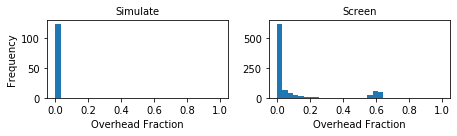

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.), sharex=True)

for data, label, ax in zip([result_data, screen_data], ['Simulate', 'Screen'], axs.flatten()):
    ax.hist(data['overhead_frac'].tolist(), bins=np.linspace(0, 1, 32))
    ax.set_xlabel('Overhead Fraction')
    ax.set_title(f'{label}', fontsize=10)
    
axs[0].set_ylabel('Frequency')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'overhead-fraction.svg'))

### Explain the overhead
See if we can explain the overhead events for the tasks

Compute each step

In [12]:
for data in [result_data, screen_data]:
    data['client_to_method-server'] = data['time_input_received'] - (data['time_created'] + data['time_serialize_inputs'])
    data['method-server_to_worker'] = data['time_compute_started'] - data['time_input_received']
    data['worker_to_method-server'] = data['time_result_sent'] - (data['time_compute_started']
                                                                  + data['time_running']
                                                                  + data['time_deserialize_inputs']
                                                                  + data['time_serialize_results'])
    data['method-server_to_client'] = data['time_result_received'] - (data['time_result_sent'] + data['time_deserialize_results'])
    data['serialization'] = data[[c for c in data.columns if c.startswith('time_') and 'serialize' in c]].sum(axis=1)

Plot overheads

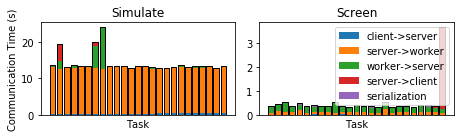

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.))

for data, label, ax in zip([result_data, screen_data],
                           ['Simulate', 'Screen'], 
                           axs.flatten()):
    subset = data.sort_values('time_created', ascending=True).tail(min(25, len(data)))
    steps = ['client_to_method-server', 'method-server_to_worker', 'worker_to_method-server', 'method-server_to_client', 'serialization']
    x = np.arange(len(subset))
    for i in range(len(steps)):
        start = subset[steps[:i]].sum(axis=1).values
        ax.bar(x, subset[steps[i]].values, bottom=start, label=steps[i].replace("_to_", "->").replace('method-server', 'server'))
    ax.bar(x, subset['overhead_time'].values, edgecolor='k', facecolor='none', lw=1)
    
    ax.set_xticks([])
    ax.set_title(label)
    ax.set_xlabel('Task')
    
axs[-1].legend()
axs[0].set_ylabel('Communication Time (s)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'overhead-breakdown.svg'))

*Finding*: It generally seems like the time from the task being recieved by the method server to starting on the compute note is generally the longest. Need to figure out what the issue is.

## Plot the Number of Results Being Run at a Time
We can look at the completed QC records to compute the utilization

Find the events related to calculations starting and finishing

In [14]:
start_time = min([tasks['time_created'].min() for tasks in [result_data, screen_data]])

In [15]:
events = [{'time': 0}]
for tag, tasks in zip(['qc', 'ml'], [result_data, screen_data]):
    col = f'{tag}_active_delta'
    events.extend({'time': t - start_time, col: -1} for t in tasks[['time_compute_started', 'time_running']].sum(axis=1))
    events.extend({'time': t - start_time, col: 1} for t in tasks['time_compute_started'])
events = pd.DataFrame(events)

In [16]:
events[events.isnull()] = 0  # If no change, the delta is zero

Make the results easier to plot

In [17]:
events.sort_values('time', ascending=True, inplace=True)

In [18]:
assert events.columns[0] == 'time'

In [19]:
for col in events.columns[1:]:
    tag = col.split("_")[0]
    events[f'{tag}_num_active'] = events[col].cumsum()

In [20]:
events.tail()

,time,qc_active_delta,ml_active_delta,qc_num_active,ml_num_active
10,9963.853420,-1.0,0.0,4.0,0.0
74,9989.573954,-1.0,0.0,3.0,0.0
5,10063.655377,-1.0,0.0,2.0,0.0
42,10127.001645,-1.0,0.0,1.0,0.0
39,10363.848729,-1.0,0.0,0.0,0.0


Compute worker utilization

In [21]:
events['qc_utilization'] = np.clip(events['qc_num_active'] / run_info['qc_workers'], 0, 1)

In [22]:
events['ml_utilization'] = np.clip(events['ml_num_active'] / run_info['nnodes'], 0, 1)

In [23]:
events['utilization'] = events['qc_utilization'] + events['ml_utilization']

Compute the cumulative utilization

In [24]:
def cumulative_utilization(time: float) -> float:
    """Compute average utilization over time"""
    # Integrating knowing that we have a piecewise functions
    # Integrate over all of the pieces before the current piece
    past_events = events[events.time <= time]
    if len(past_events) <= 1:
        return 0.0
    past_util = (np.diff(past_events['time'].values) * past_events['utilization'].values[:-1]).sum()
    
    # Integrate the current piece
    current_event = past_events.iloc[-1]
    current_util = (time - current_event.time) * current_event.utilization
    return (past_util + current_util) / time

In [25]:
times = np.linspace(0, events.time.max(), 1024)
utilization = np.array([cumulative_utilization(x) for x in times])

In [26]:
print(f'Best cumulative utilization: {utilization.max()*100:.2f}%')

Best cumulative utilization: 87.83%


Plot the queue length and utilization

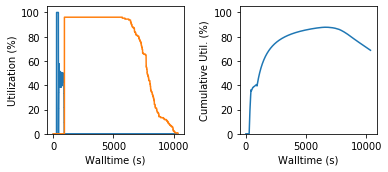

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['time'], events['ml_utilization'] * 100, where='post')
ax.step(events['time'], events['qc_utilization'] * 100, where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

ax = axs[1]
ax.plot(times, utilization * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Cumulative Util. (%)')
ax.set_ylim(0, 105)

fig.tight_layout()
fig.savefig('figures/utilization-over-time.svg')

*Finding*: Utilization stays around ~90% for the most of the run. The dropoff towards the end is because tasks that launched did not complete before the end of the allocation period.

Text(0, 0.5, 'Task Submit Rate (1/s)')

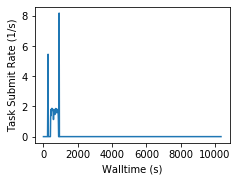

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

window_size = 15
window_bin = np.arange(0, events.time.max(), window_size)
counts = [len(events.query(f'(qc_active_delta == 1 or ml_active_delta == 1) and {i} <= time < {i+window_size}')) / window_size for i in window_bin]

ax.plot(window_bin, counts)

ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Task Submit Rate (1/s)')